# RAI Exercise 1: Algorithmic Fairness ⚖️

# Important information
This exercise is part of the RAI course (02517 - **Responsible AI: Algorithmic Fairness and Explainability**) at the Technical University of Denmark (DTU). You can find more details about the course [here](https://kurser.dtu.dk/course/02517). This specific version is for the Fall 2024 semester.

If you have any questions related to this notebook, feel free to reach out to Nina Weng at *ninwe@dtu.dk*.

**Credits**:  
We thank:
* NIH dataset team for collecting such dataset [link to the paper](https://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf);
* Authors from [this paper](https://link.springer.com/chapter/10.1007/978-3-031-45249-9_14) for providing the splits;
* [Memes generator webpage imgflip](https://imgflip.com/) for all the excellent Memes template.


# PART 1: Fairness assessment and Bias mitigation using Fairlearn

The goal of this exercise is to learn how to use [Fairlearn](https://fairlearn.org/) to approach basic fairness assessments and apply post-processing bias mitigation methods. 

Fairlearn is an open-source Python package originally developed by Microsoft Research. Since 2021, it has become completely community-driven. For more information about Fairlearn, you can visit [this page]((https://fairlearn.org/v0.10/about/index.html)). 

Although Fairlearn is likely the most well-developed package targeting fairness issues, it has its limitations. The most notable limitation, that might need to be mentioned at very beginning for this exercise, is that Fairlearn is primarily designed for tabular data ([this page](https://fairlearn.org/main/faq.html) under question: *Does Fairlearn work for image and text data?*). Therefore, when working with other types of data, such as image data, unexpected issues may arise. Fortunate enough, there are workarounds for most of these issues, which will be discussed later in this exercise.

While Fairlearn is a good resource and offers an easy approach for learning fairness concepts and handling lighter tasks, it may not be the best solution for researchers working extensively in this area. Keep that in mind :-)

## 🧠 Objective of this Exercise (PART 1)
By the end of this exercise, you should be able to:

* Assess fairness using Fairlearn with provided predictions/probabilities and target labels. This includes calculating metrics, generating ROC curves, and interpreting their meaning.
* Apply post-processing bias mitigation techniques using Fairlearn, and clearly understand and explain the outcomes.

![](./support4notebook/getstarted.jpg)

## 1. Dataset: Chest X-ray and lung/heart related disease


In this exercise, we will use a chest X-ray dataset and a basic deep learning model as the setup. It requires the following:

* Download the dataset/metadata/pretrained ResNet model. Note that in this exercise, we only use part of the data, and details are listed below. The full dataset can be found [here](https://nihcc.app.box.com/v/ChestXray-NIHCC). (For students in the class, you can find a download link on DTU Learn. For those not in the class, you can find the pre-processing scripts in [this repository](https://github.com/nina-weng/detecting_causes_of_gender_bias_chest_xrays).)
* After downloading the materials, put the `NIH_train_val_test_rs0_f50.csv` under `./datafiles/`; and `nih_pneumothorax.pth` under `./pretrained_model/`.
* Prepare your virtual environment: 
`conda env create -f env.yml`


### Chest xray samples
We use [NIH chest xray dataset](https://www.nih.gov/news-events/news-releases/nih-clinical-center-provides-one-largest-publicly-available-chest-x-ray-datasets-scientific-community) in this exercise. Let’s take a closer look at the dataset. </br>

This dataset contains 108,948 images from 32,717 patients, each labeled with one of 14 types of lung or heart-related diseases/symptoms. For detailed information on each disease, you can find explanations [here](https://nihcc.app.box.com/v/ChestXray-NIHCC/file/220660789610).

For simplicity, we will use only one sample per patient and preprocess the images to a size of 224x224. Both the dataset and the metadata (in CSV format) are available. The dataset split is also specified in the metadata under the column 'split'.

Note: The split was designed for a different task, which required a larger test set than usual. As a result (as you’ll notice), the test set is relatively large (around 8k for training, 2k for validation, and 8k for testing). If you find that the mitigation or prediction process takes too long, feel free to downsample the test set. Just ensure you validate that the proportions of samples across different sensitive groups and disease labels remain roughly consistent with the original test set.  

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")
import torch
import numpy as np
import json

from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score
from fairlearn.metrics import MetricFrame, selection_rate, false_positive_rate, true_positive_rate, false_negative_rate, true_negative_rate, count
from fairlearn.metrics import equalized_odds_ratio, demographic_parity_ratio, true_positive_rate_ratio


# 
from train.model import ResNet
from train.prediction import validate
from analysis.plot import plot_roc_simple

c:\Users\satmo\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#TODO: change this to your data directory
datadir = './datafiles'

Let us take a look of some samples, with filter query. 

,Image Index,Patient ID,Patient Age,Patient Gender,View Position,Effusion,Emphysema,Nodule,Atelectasis,Infiltration,...,Pneumothorax,Consolidation,Fibrosis,Cardiomegaly,Pneumonia,Edema,Hernia,No Finding,split,sex_label
0,00000041_002.png,41,62,F,PA,0,1,0,0,0,...,1,0,0,0,0,0,0,0,train,0
1,00000116_021.png,116,74,F,AP,1,0,0,0,0,...,1,0,0,0,0,0,0,0,train,0
2,00000211_023.png,211,59,F,PA,0,0,0,0,0,...,1,0,0,0,0,0,0,0,train,0
3,00000261_004.png,261,39,F,AP,0,0,0,0,0,...,1,0,0,0,0,0,0,0,train,0
4,00000416_005.png,416,67,F,PA,0,0,0,0,0,...,1,0,0,0,0,0,0,0,train,0


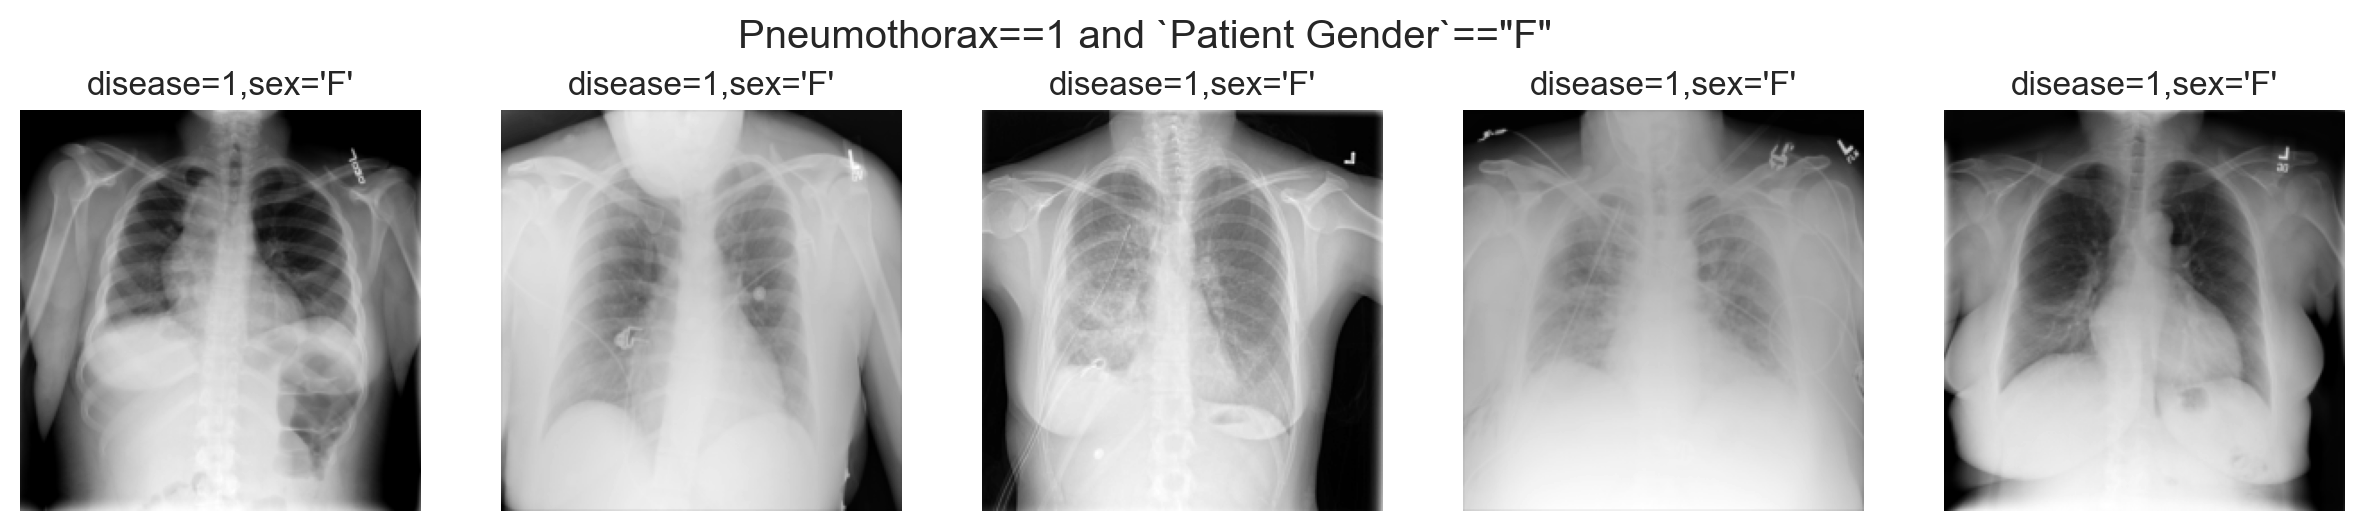

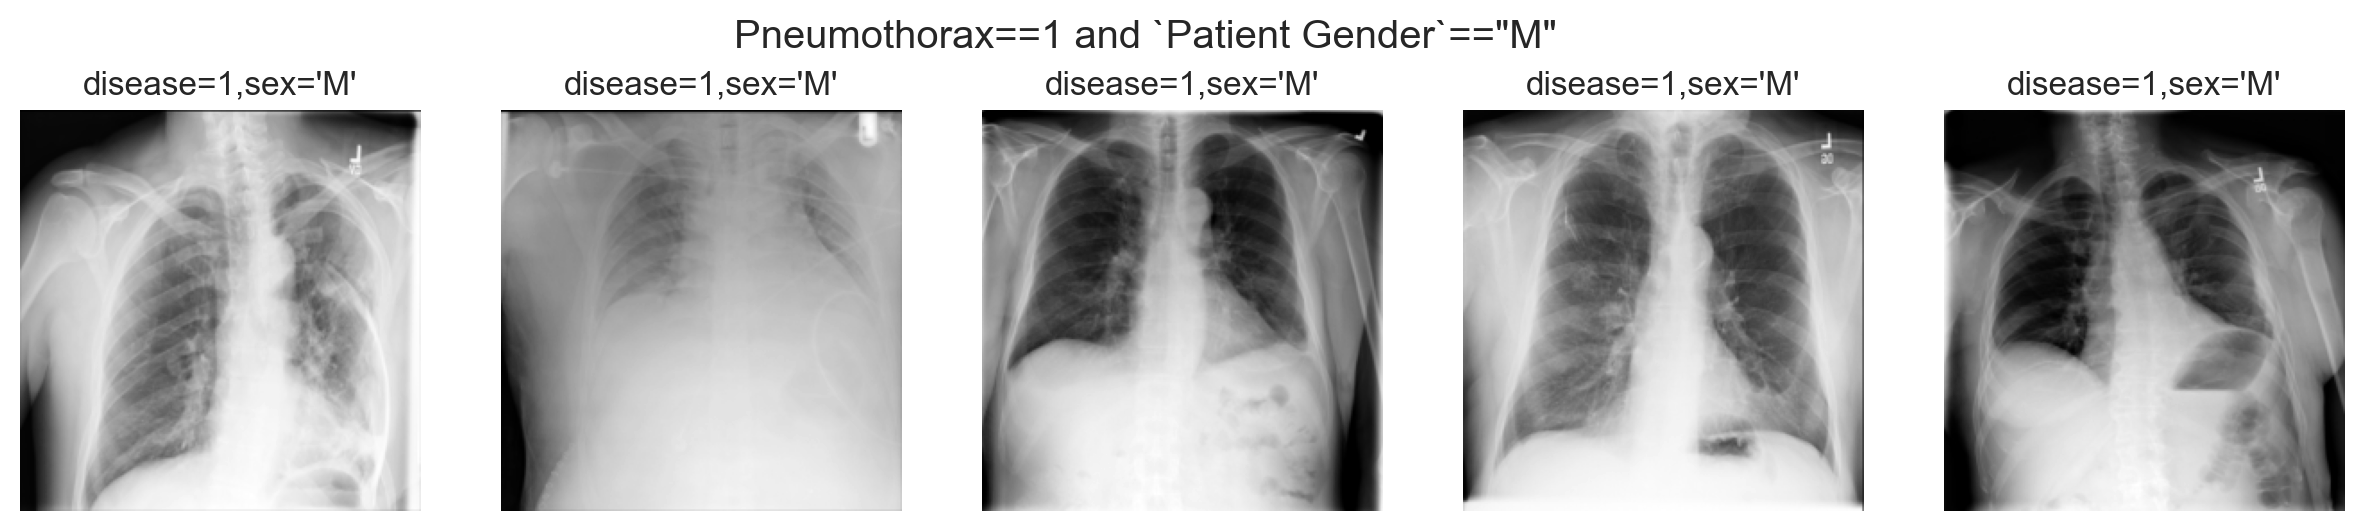

In [3]:
dataset_pth = datadir + '/NIH_part/'
metadata_csv ='./datafiles/NIH_train_val_test_rs0_f50.csv'
metadata = pd.read_csv(metadata_csv)

display(metadata.head(5))

# randomly choose some samples from PAD-UFES-20
def show_random_images(datadir,metadata,seed=None,filter_str=None,num_sample=5):
    fig = plt.figure(figsize=(num_sample*3, 3),dpi=200)
    files = os.listdir(datadir)
    if filter_str:
        metadata = metadata.query(filter_str)
        # display(metadata.head(5))
    if seed is not None:
        random_sample = metadata.sample(n=num_sample, random_state=seed)
    else: random_sample = metadata.sample(n=num_sample)
    
    for i in range(len(random_sample)):
        row = random_sample.iloc[i]
        disease = row['Pneumothorax']
        sex = row['Patient Gender']

        img = mpimg.imread(datadir + row['Image Index'])
        ax = fig.add_subplot(1, len(random_sample), i + 1)
        # add diagnosis as subtitle
        ax.set_title(f'{disease=},{sex=}')
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    plt.suptitle(f'{filter_str}')
    plt.show()

show_random_images(dataset_pth,metadata=metadata,seed=42,filter_str='Pneumothorax==1 and `Patient Gender`=="F"',num_sample=5)
show_random_images(dataset_pth,metadata=metadata,seed=42,filter_str='Pneumothorax==1 and `Patient Gender`=="M"',num_sample=5)

### Basic statistics

We can also take a look at the distribution of some sensitive attributes:

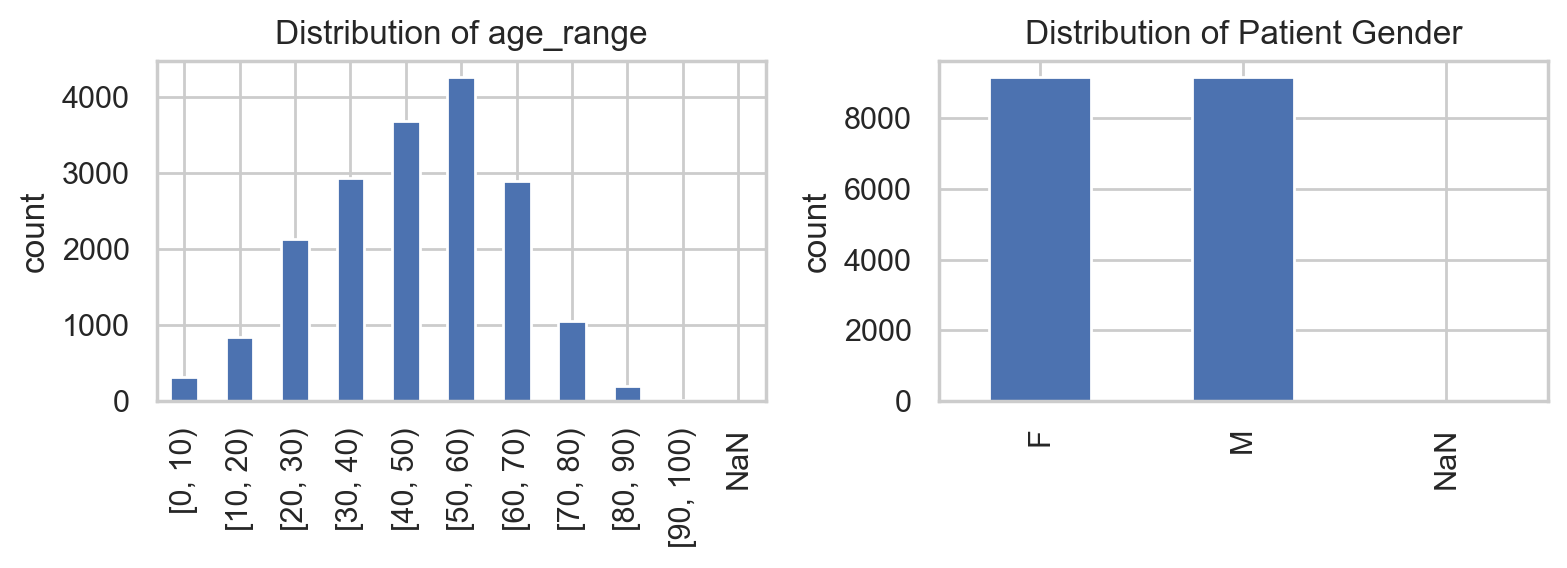

In [4]:
def plot_distribution_by_value(metadata, column_name):
    if isinstance(column_name, str):
        nan_count = metadata[column_name].isna().sum()
        nan_series = pd.Series([nan_count], index=['NaN'])
        counts_ = metadata[column_name].value_counts().sort_index()
        counts_with_nan = pd.concat([counts_, nan_series])

        counts_with_nan.plot(kind='bar',title='Distribution of {}'.format(column_name))
        plt.ylabel('count')
    elif isinstance(column_name, list):
        fig, axes = plt.subplots( 1, len(column_name), figsize=( len(column_name)*4,3),dpi=200)
        for i,col in enumerate(column_name):
            nan_count = metadata[col].isna().sum()
            nan_series = pd.Series([nan_count], index=['NaN'])
            counts_ = metadata[col].value_counts().sort_index()
            counts_with_nan = pd.concat([counts_, nan_series])

            counts_with_nan.plot(kind='bar',title='Distribution of {}'.format(col),ax=axes[i])
            axes[i].set_ylabel('count')
    plt.tight_layout()
    plt.show()

metadata['age_range'] = pd.cut(metadata['Patient Age'], bins=[0,10,20,30,40,50,60,70,80,90,100], right=False)
plot_distribution_by_value(metadata, ['age_range','Patient Gender'])

You may have noticed that, for this specific split, we maintain an equal number of male and female samples. This balance is consistent across all three splits: training, validation, and testing.

### 📃 Further Reading:
If you're interested, here are some studies that explore potential biases and confounders in chest xray datasets:
* [Lauren Oakden-Rayner: Exploring the ChestXray14 dataset: problems](https://laurenoakdenrayner.com/2017/12/18/the-chestxray14-dataset-problems/)
* [Amelia Jiménez-Sánchez et al.: Detecting Shortcuts in Medical Images -- A Case Study in Chest X-rays](https://arxiv.org/abs/2211.04279)
* [Judy Wawira Gichoya et al.: AI recognition of patient race in medical imaging: a modelling study](https://www.thelancet.com/journals/landig/article/PIIS2589-7500(22)00063-2/fulltext)

## 2. Fairness assessment
**Recap of Key Concepts**:

In the class, we have learned:
* The three key criteria for fairness assessment. What are they?
* Evaluation metrics corresponding to each criterion.
* ROC curves.

For this exercise, we’ve provided a pre-trained ResNet classifier for Part 1, where the disease label is `Pneumothorax` and the sensitive attribute is `sex` (in metadata, you can get the binarized sex label from column `sex label`, where 0 represents female and 1 represents male). However, feel free to train your own model if you'd like.



### Load pretrained model

In [5]:
# load the pretrained model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu' # test
print(' device:', device)

ds_name = 'NIH'

# load the model
lr=1e-6
pretrained = True
model_scale = '18'
num_epochs = 20
img_size = (1, 224, 224)

classifier = ResNet(num_classes=1, lr=lr, pretrained=pretrained, model_scale=model_scale, in_channel=img_size[0])
classifier.load_state_dict(torch.load('./pretrained_model/nih_pneumothorax.pth', map_location=device))
classifier.to(device)

classifier.eval()


 device: cpu


c:\Users\satmo\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
c:\Users\satmo\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

### Load test and validation data

In [6]:
save_model_at = './pretrained_models/'

img_size = (1,224,224)
batch_size = 16

csv_pth = './datafiles/NIH_train_val_test_rs0_f50.csv' if ds_name == 'NIH' else None

disease_label = 'Pneumothorax' 
sensitive_label = 'sex'
augmentation = False

from train.train_chestxray import create_datasets

train_dataset, val_dataset, test_dataset = create_datasets(dataset_pth, 
                                                               ds_name,
                                                               csv_pth, 
                                                               image_size=img_size, 
                                                               device=device,
                                                               disease_label = disease_label,
                                                               sensitive_label = sensitive_label,
                                                               augmentation=augmentation)
# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # we dont need it here
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Loading Data: 100%|██████████| 8459/8459 [00:00<00:00, 34182.63it/s]


### Predict the results for both validation and test set

In [7]:
val_lab, val_pred, val_prob, val_a = validate(classifier, val_loader, device=device)
test_lab, test_pred, test_prob, test_a= validate(classifier, test_loader, device=device)

100%|██████████| 89/89 [00:39<00:00,  2.24it/s]


val_loss=1.2286 val_acc=0.8211 val_auroc=0.7841


100%|██████████| 529/529 [03:31<00:00,  2.51it/s]

val_loss=1.2348 val_acc=0.8092 val_auroc=0.7726


If predicting on the validation/test set takes too long, you can simply load the pre-saved results directly from the CSV file. Note that if you use your own model, the results will differ from mine.

In [8]:
# # read the results from csv
# val_df = pd.read_csv('./datafiles/nih_val_results.csv')
# test_df = pd.read_csv('./datafiles/nih_test_results.csv')

# val_lab, val_pred, val_prob, val_a = val_df['val_lab'].values, val_df['val_pred'].values, val_df['val_prob'].values, val_df['val_a'].values
# test_lab, test_pred, test_prob, test_a = test_df['test_lab'].values, test_df['test_pred'].values, test_df['test_prob'].values, test_df['test_a'].values

### Assess fairness using Fairlearn
#### A simple example first

Fairlearn provides the `fairlearn.metrics.MetricFrame` class to help with this quantification. 

Given: 
<pre>
y_true = [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1]
y_pred = [0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0]
sf_data = ['b', 'b', 'a', 'b', 'b', 'c', 'c', 'c', 'a',
           'a', 'c', 'a', 'b', 'c', 'c', 'b', 'c', 'c']
</pre>
           


![](./support4notebook/exercise_time.gif)

Try: 
* measure: recall, selection rate and false positive rate for *each group*;
* plot the above result out; ([Hint](https://fairlearn.org/main/user_guide/assessment/plotting.html))
* measure the difference in eqaulized odd between different groups;


Hint: The documentation page of [MetricFrame](https://fairlearn.org/main/api_reference/generated/fairlearn.metrics.MetricFrame.html#fairlearn.metrics.MetricFrame)

### Now measure the fairness metrics for our data

![](./support4notebook/exercise.jpg)

Test set fairness metrics (before mitigation):
                     accuracy  precision  selection rate  false positive rate  \
sensitive_feature_0                                                             
0.0                  0.769213   0.140504        0.244029             0.222028   
1.0                  0.849173   0.150456        0.155556             0.137957   

                     false negative rate  true positive rate  \
sensitive_feature_0                                            
0.0                             0.380342            0.619658   
1.0                             0.443820            0.556180   

                     true negative rate   count  
sensitive_feature_0                              
0.0                            0.777972  4229.0  
1.0                            0.862043  4230.0  
Recall is the true positive rate (TPR).


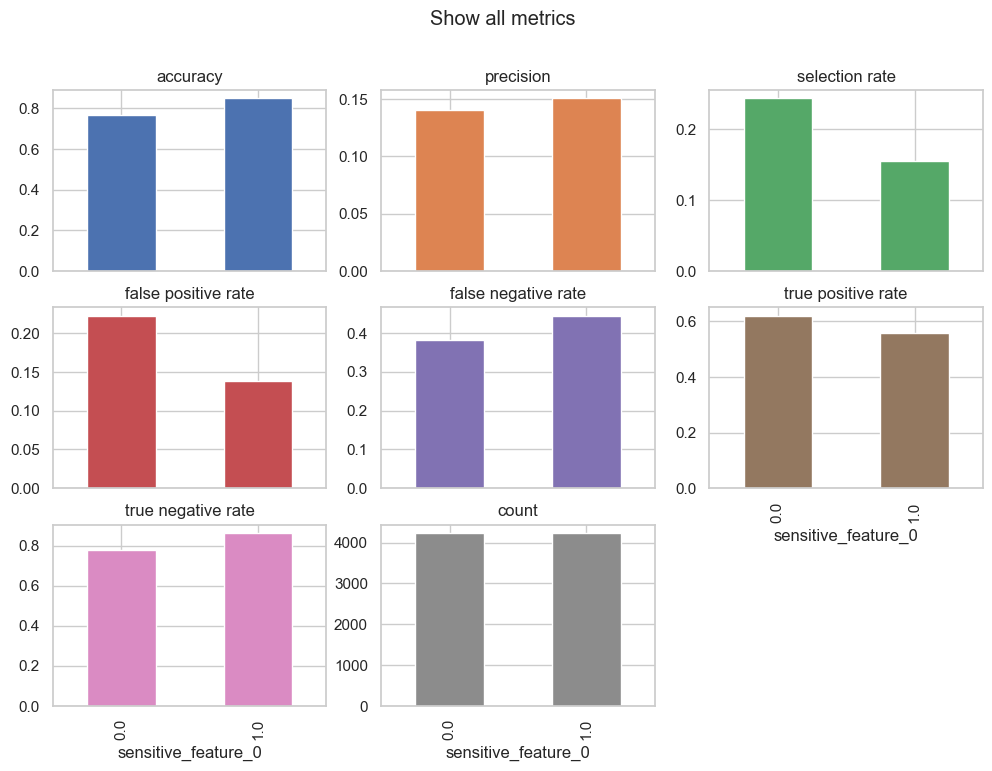

In [9]:
mf = MetricFrame(metrics={"accuracy": accuracy_score,
                        "precision": precision_score,
                        "selection rate": selection_rate,
                        "false positive rate": false_positive_rate,
                        "false negative rate": false_negative_rate,
                        "true positive rate": true_positive_rate,
                        "true negative rate": true_negative_rate,
                        "count": count
                         },
                 y_true=test_lab,
                 y_pred=test_pred,
                 sensitive_features=test_a)




print("Test set fairness metrics (before mitigation):")
print(mf.by_group)


mf.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

print("Recall is the true positive rate (TPR).")

In [10]:
# Separation ratio (equalized odds, same FPR and FNR)
print('Separation ratio:', equalized_odds_ratio(test_lab, test_pred, sensitive_features=test_a)) 

# Independence ratio
print('Independence ratio:', demographic_parity_ratio(test_lab, test_pred, sensitive_features=test_a))

# Sufficiency ratio (PPV positive predictive value,  PPV = TP / (TP + FP), precision)
print('Sufficiency ratio (manual):', min(mf.by_group['precision']) / max(mf.by_group['precision']))

Separation ratio: 0.6213489017073422
Independence ratio: 0.6374461670973299
Sufficiency ratio (manual): 0.9338540443191605


### Draw the ROC curve

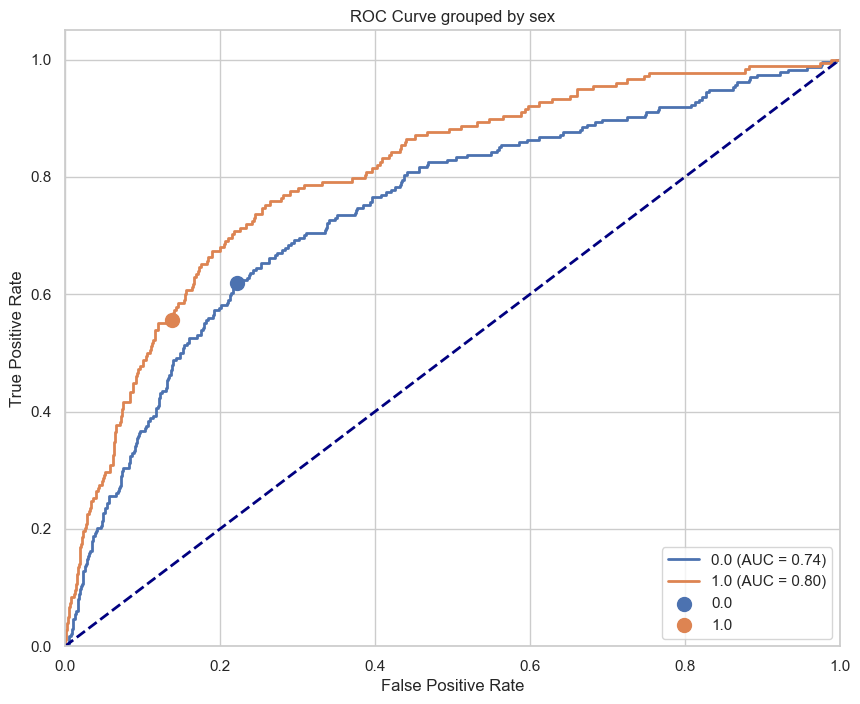

In [11]:
plot_roc_simple(test_lab, test_prob, test_a, test_pred,
        sensitive_attribute_name = 'sex',
        )

### 💥 Exercise and discusssion:
* What do you see from the metrics and the ROC curve?
* Try to measure and describe the fairness wrt. the 3 criterias we learned from class

Its biased. Better at predicting men. The fairness diagnostic metrics: separation and independence ratios, does not live up to the "less than 20% discrepency" rule. The suffiency ratio does, however. Since this is a medical case, we care more about the suffiency (PPV positive predictive value,  PPV = TP / (TP + FP), precision), since finding tp's is very important.

## 3. Bias mitigation using Fairlearn

### Recall from the class
* what kinds of mitigation methods have we learned?

In this exercise, we will try to use the one of the post-preprocessing bias mitigation method Fairlearn provided: **Threshold Optimization**, to implement the bias mitigation steps. 

### The theory of Threshold Optimization


The idea could be simply visualized as below (figure from the [original paper](https://arxiv.org/pdf/1610.02413)):  
![](./support4notebook/threshold_op.png)

Where blue/green represent two sensitive groups, any points in the overlapping region meet the requirement of equalized odds:

$$
\gamma_0(\hat{Y}) = \gamma_1(\hat{Y}),
$$

where 

$$
\gamma_a (\hat{Y}) = \left(Pr(\hat{Y} = 1 | A = a, Y = 0), Pr(\hat{Y} = 1 | A = a, Y=1)\right).
$$

The goal of the threshold optimizer is to find the point in the overlapping region that optimizes the objective function, such as balanced accuracy.

To achieve this, **randomization** is introduced. The idea is starightforward: any point under the ROC curve can be estimated by weighting two points on the ROC curve (which could be achieved by simply thresholding); or in another word, a new decision threshold $T_a$ can be a randomized mixture of two decision thresholds $\underline{t}_a$ and $\overline{t}_a$.

(See the figure below, which is from [this paper](https://arxiv.org/abs/2202.08536)).

![Randomization Figure](./support4notebook/randomization.png)


📃 Further Reading:
* [Fairlearn *ThresholdOptimizier* page](https://fairlearn.org/v0.5.0/api_reference/fairlearn.postprocessing.html).
* The original paper (See section 3): [Equality of opportunity in supervised learning](https://arxiv.org/pdf/1610.02413).




### 🪄 Trick: A fake classifier class

Fairlearn has some limitations when implementing the `ThresholdOptimizer` method. To work around these issues, a fake classifier is provided to bypass minor problems. If you use the provided classifier, this fake class should work just as well.

However, if you're curious about what went wrong or want to use your own classifier, please read below:

* **Problem 1: `estimator` in `ThresholdOptimizer` only accepts 2D input (tabular data).** This doesn’t make sense for post-processing mitigation methods, as the only relevant aspect here is the prediction scores from the test set. The classifier itself and the input data are irrelevant when optimizing the threshold.
  
* **Problem 2: The `prefit` parameter checks whether the model has been fitted in a simplistic way, leading to errors.** You can read more about this fit check function [here](https://scikit-learn.org/stable/modules/generated/sklearn.utils.validation.check_is_fitted.html).
  
* **Problem 3: It requires the prediction function to return scores for both classes in binary classification.** This might be an issue if your classifier only provides the probability for class 1.

**How we solve this**: We create a fake classifier called `IdentityClassifier`, which takes the pre-computed probabilities as input and simply returns them unchanged.

Note: If you trained your own classifier, you might need to change the following code a bit.

### Optimize on validation set

In [12]:
from sklearn.base import BaseEstimator, ClassifierMixin

class IdentityClassifier(BaseEstimator,ClassifierMixin):
    '''
    Fake classifier that takes 2D input, with pre-trained model that does not take 2D input data
    '''
    def __init__(self,):
        self.fit_ = True # fake the check_fit function inside the fairlearn library

    def fit(self,x,y,sensitive_features=None):
        # Do not need to fit
        return

    def predict(self, y_prob_2D, ):
        # predict function returns the index of the maximum probability for each sample
        assert len(y_prob_2D.shape) == 2, "Input should be 2D array, which contains probabilities for each class"
        return y_prob_2D.argmax(axis=1)
    
    def predict_proba(self, y_prob_2D):
        # predict_proba function returns the probabilities for each class
        assert len(y_prob_2D.shape) == 2, "Input should be 2D array, which contains probabilities for each class"
        return y_prob_2D

Your code here:

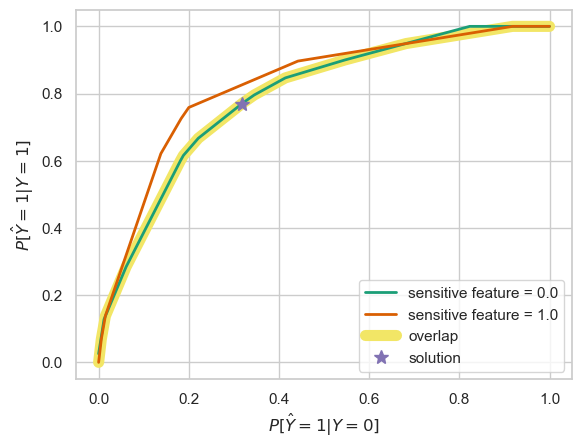

In [ ]:
from fairlearn.postprocessing import ThresholdOptimizer


val_prob = np.array(val_prob, dtype=np.float32)
val_prob_2D = np.column_stack((1 - val_prob, val_prob))
identityclf= IdentityClassifier()

# chose an optimization method from fairlearn, you can choose ThresholdOptimizer
#TODO
postprocessor = ThresholdOptimizer(
    estimator=identityclf,
    constraints="equalized_odds",
    objective="balanced_accuracy_score",
    prefit=False,
)

# fit it with validation data
#TODO
postprocessor.fit(val_prob_2D,val_lab, sensitive_features=val_a)
y_pred = postprocessor.predict(val_prob_2D, sensitive_features=val_a)


# plot the optimizing result using plot_threshold_optimizer
#TODO
from fairlearn.postprocessing import plot_threshold_optimizer
plot_threshold_optimizer(postprocessor)


Validation set fairness metrics (after mitigation):
                     accuracy  precision  selection rate  false positive rate  \
sensitive_feature_0                                                             
0.0                  0.687943   0.124481        0.341844             0.316817   
1.0                  0.691761   0.084071        0.321023             0.306667   

                     false negative rate  true positive rate  \
sensitive_feature_0                                            
0.0                             0.230769            0.769231   
1.0                             0.344828            0.655172   

                     true negative rate  
sensitive_feature_0                      
0.0                            0.683183  
1.0                            0.693333  


<Axes: xlabel='sensitive_feature_0'>

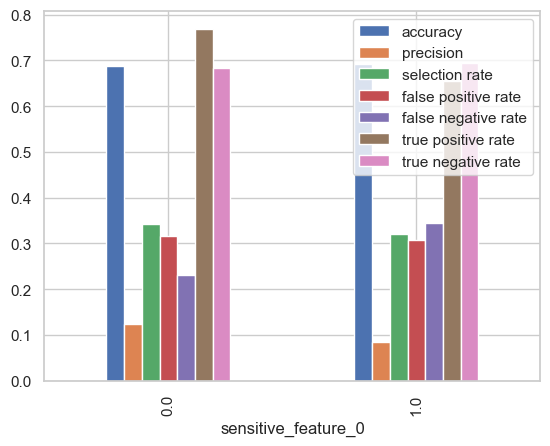

In [14]:
#plot the results
# --- IGNORE ---
mf_post = MetricFrame(metrics={"accuracy": accuracy_score,
                        "precision": precision_score,
                        "selection rate": selection_rate,
                        "false positive rate": false_positive_rate,
                        "false negative rate": false_negative_rate,
                        "true positive rate": true_positive_rate,
                        "true negative rate": true_negative_rate,
                         },
                 y_true=val_lab,
                 y_pred=y_pred,
                 sensitive_features=val_a)
print("Validation set fairness metrics (after mitigation):")
print(mf_post.by_group)
mf_post.by_group.plot.bar()

### Use the new threshold for the test set

Your code here

In [24]:
# Make predictions
test_prob = np.array(test_prob, dtype=np.float32)
test_prob_2D = np.column_stack((1 - test_prob, test_prob))

# predict the test set using the fitted optimizer 
#TODO
y_pred_fair_test = postprocessor.predict(test_prob_2D, sensitive_features=test_a)

Test set fairness metrics (after mitigation):
                     accuracy  precision  selection rate  false positive rate  \
sensitive_feature_0                                                             
0.0                  0.677938   0.113169        0.344762             0.323655   
1.0                  0.649409   0.081999        0.369031             0.353653   

                     false negative rate  true positive rate  \
sensitive_feature_0                                            
0.0                             0.294872            0.705128   
1.0                             0.280899            0.719101   

                     true negative rate  
sensitive_feature_0                      
0.0                            0.676345  
1.0                            0.646347  


<Axes: xlabel='sensitive_feature_0'>

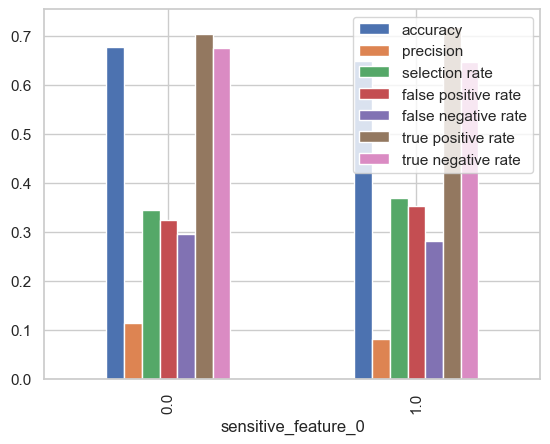

In [25]:
mf = MetricFrame(metrics={"accuracy": accuracy_score,
                        "precision": precision_score,
                        "selection rate": selection_rate,
                        "false positive rate": false_positive_rate,
                        "false negative rate": false_negative_rate,
                        "true positive rate": true_positive_rate,
                        "true negative rate": true_negative_rate,
                         },
                 y_true=test_lab,
                 y_pred=y_pred_fair_test,
                 sensitive_features=test_a)
print("Test set fairness metrics (after mitigation):")
print(mf.by_group)
mf.by_group.plot.bar()

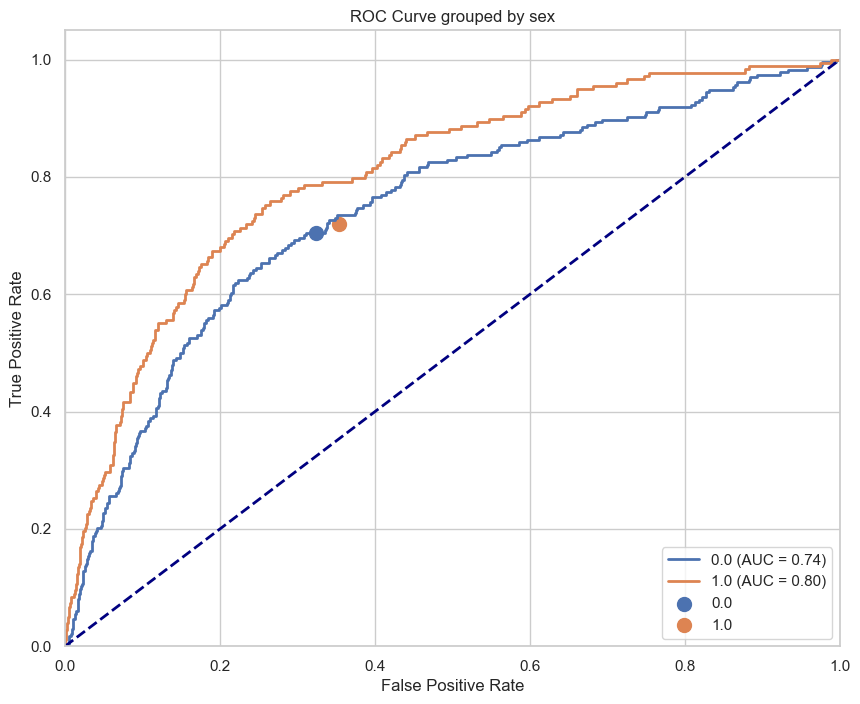

In [26]:
plot_roc_simple(test_lab, test_prob, test_a, y_pred_fair_test,
        sensitive_attribute_name = 'sex',
        )

### To find out how the prediction come from (the new threshold $T_a$)

In [27]:
threshold_rules_by_group = postprocessor.interpolated_thresholder_.interpolation_dict
print(json.dumps(threshold_rules_by_group, default=str, indent=4))

{
    "0.0": {
        "p_ignore": 0.0,
        "prediction_constant": 0.317,
        "p0": 0.9932222222222229,
        "operation0": "[>0.3068544566631317]",
        "p1": 0.006777777777777105,
        "operation1": "[>0.2707941383123398]"
    },
    "1.0": {
        "p_ignore": 0.11022723354625812,
        "prediction_constant": 0.317,
        "p0": 0.5154907975460122,
        "operation0": "[>0.24994409829378128]",
        "p1": 0.48450920245398776,
        "operation1": "[>0.0645340234041214]"
    }
}


In [28]:
# Separation ratio (equalized odds, same FPR and FNR)
print('Separation ratio:', equalized_odds_ratio(test_lab, y_pred_fair_test, sensitive_features=test_a)) 

# Independence ratio
print('Independence ratio:', demographic_parity_ratio(test_lab, y_pred_fair_test, sensitive_features=test_a))

# Sufficiency ratio (PPV positive predictive value,  PPV = TP / (TP + FP), precision)
print('Sufficiency ratio (manual):', min(mf.by_group['precision']) / max(mf.by_group['precision']))

Separation ratio: 0.9151767692868005
Independence ratio: 0.9342375159225924
Sufficiency ratio (manual): 0.7245704967678062


now it is the other way around, separation ratio and independence ratio lives up to the "less than 20 % discrepency" but sufficiency doesnt. We still care more about sufficiency since it is a medical case, so while it might be more "fair", it will most likely cost more people their lives slay.

### 💥 Exercise and Discussion:
* Can you write down the new threshold function? ([Hint](https://fairlearn.org/v0.10/user_guide/mitigation/postprocessing.html#postprocessing))

from link (for equalized odds constraint):

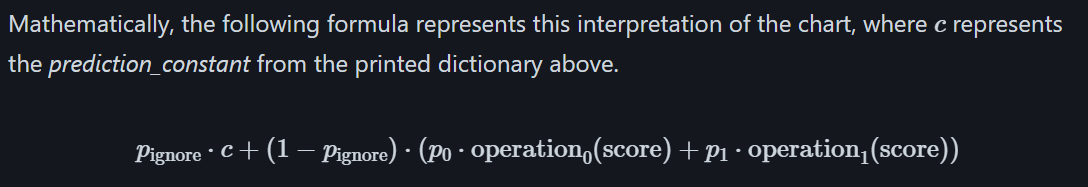

So, for group 0.0 (female):

$0.993 \cdot \mathbb{I}(score>0.307) + 0.007 \cdot \mathbb{I}(score>0.271)$

meaning with prob. $0.933$ use threshold $0.307$ and with prob. $0.007$ use threshold $0.271$.

For group 1.0 (male):

$0.11 \cdot 0.317 + (1 - 0.11) \cdot (0.515 \cdot \mathbb{I}(score>0.25) + 0.485 \cdot \mathbb{I}(score>0.065))$

meaning with prob. $0.11$ ignore the sample, with prob. $0.515$ use threshold $0.25$, with prob. $0.485$ use threshold $0.065$, and if neither applies, predict constant value $0.317$.

(if predicted prob. that a sample belongs to positive class, eg. has disease, is above threshold, it is classified as positive, for example for females: if score is above $0.307$ predict $1$, if score is between $0.307$ and $0.271$ predict $1$ with prob. $0.007$)

* Compare the results. What do you observe, and does this model seem fair to you?
* Hint: After optimization, you may notice that accuracy (or other metrics) is more balanced between groups. However, the overall accuracy (or other metrics of interest) may decrease for both groups. Do you think this is still a good or acceptable solution?


![](./support4notebook/dilemma.jpg)

# PART 2: Potential pitfall: Algorithmic fairness in the presence of label noise
As mentioned in class, it is easy to diagnose algorithmic bias. This is, however, only true if we have access to correct target labels for the test set. In this part of the project, we will simulate a situation where our test set ground truth target labels are incorrect in a biased way: You will simulate overdiagnosis among male individuals, by manually distorting some of their labels. Next, you will analyze how this affects the diagnosis and mitigation of algorithmic bias.

## Write a script to distort the labels for the male individuals according to the following recipe:
* Please create a new set of distorted target labels
* Initialize these as identical to the supplied target labels
* Manually distort them by flipping 30% of the healthy labels for male individuals to diseased. These should be selected at random.

## Now repeat your analysis from Part 1 for your classifier from Part 1 using the distorted labels. 
You don’t need to retrain the classifier – you will only repeat the diagnosis and mitigation parts.

* Diagnose algorithmic bias with respect to your distorted labels. Do your conclusions change?
* Mitigate algorithmic bias with respect to your distorted labels. Following this, repeat your diagnostic pipeline both with respect to your distorted and original labels. What do you see? Did mitigation ensure improved fairness with respect to the distorted labels? What happened with respect to the actual (original) labels? Is the mitigated algorithm actually fair?





![](./support4notebook/dataset.jpg)

In [ ]:
# flip 30% of the healthy labels for males in test set
copy = metadata.copy()
test_mask = metadata['split'] == 'test'
copy = copy[test_mask]

display(copy.head(5))
print(f'Disease counter before flipping: {copy["Pneumothorax"].value_counts()} \n')

healthy_males = copy[(copy['Pneumothorax'] == 0) & (copy['sex_label'] == 1)]
#display(healthy_males.head(5))
print(f'Disease counter of healthy males: {healthy_males["Pneumothorax"].value_counts()} \n')

flips = healthy_males.sample(frac=0.3, random_state=42)
flips = flips.replace({'Pneumothorax': {0: 1}})
print(f'Disease counter of flipped healthy males: {flips["Pneumothorax"].value_counts()} \n')

copy.update(flips)
print(f'Disease counter after flipping: {copy["Pneumothorax"].value_counts()} \n')

# the new test lab
test_lab_distorted = copy['Pneumothorax'].values
display(test_lab_distorted)

,Image Index,Patient ID,Patient Age,Patient Gender,View Position,Effusion,Emphysema,Nodule,Atelectasis,Infiltration,...,Consolidation,Fibrosis,Cardiomegaly,Pneumonia,Edema,Hernia,No Finding,split,sex_label,age_range
9867,00000275_003.png,275,60,F,AP,0,0,0,0,0,...,0,0,0,0,0,0,0,test,0,"[60, 70)"
9868,00000493_000.png,493,35,F,AP,0,0,0,0,0,...,0,0,0,0,0,0,0,test,0,"[30, 40)"
9869,00000758_002.png,758,42,F,PA,0,0,0,0,0,...,0,0,0,0,0,0,0,test,0,"[40, 50)"
9870,00000798_001.png,798,60,F,PA,0,0,0,0,1,...,0,0,1,0,0,0,0,test,0,"[60, 70)"
9871,00001248_036.png,1248,33,F,PA,0,0,0,0,0,...,0,0,0,0,0,0,0,test,0,"[30, 40)"


Disease counter before flipping: Pneumothorax
0    8047
1     412
Name: count, dtype: int64 

Disease counter of healthy males: Pneumothorax
0    4052
Name: count, dtype: int64 

Disease counter of flipped healthy males: Pneumothorax
1    1216
Name: count, dtype: int64 

Disease counter after flipping: Pneumothorax
0    6831
1    1628
Name: count, dtype: int64 



array([1, 1, 1, ..., 1, 1, 0], dtype=int64)

Before mitigation:

Test set fairness metrics (before mitigation):
                     accuracy  precision  selection rate  false positive rate  \
sensitive_feature_0                                                             
0.0                  0.769213   0.140504        0.244029             0.222028   
1.0                  0.632151   0.376900        0.155556             0.144570   

                     false negative rate  true positive rate  \
sensitive_feature_0                                            
0.0                             0.380342            0.619658   
1.0                             0.822095            0.177905   

                     true negative rate   count  
sensitive_feature_0                              
0.0                            0.777972  4229.0  
1.0                            0.855430  4230.0  
Recall is the true positive rate (TPR).


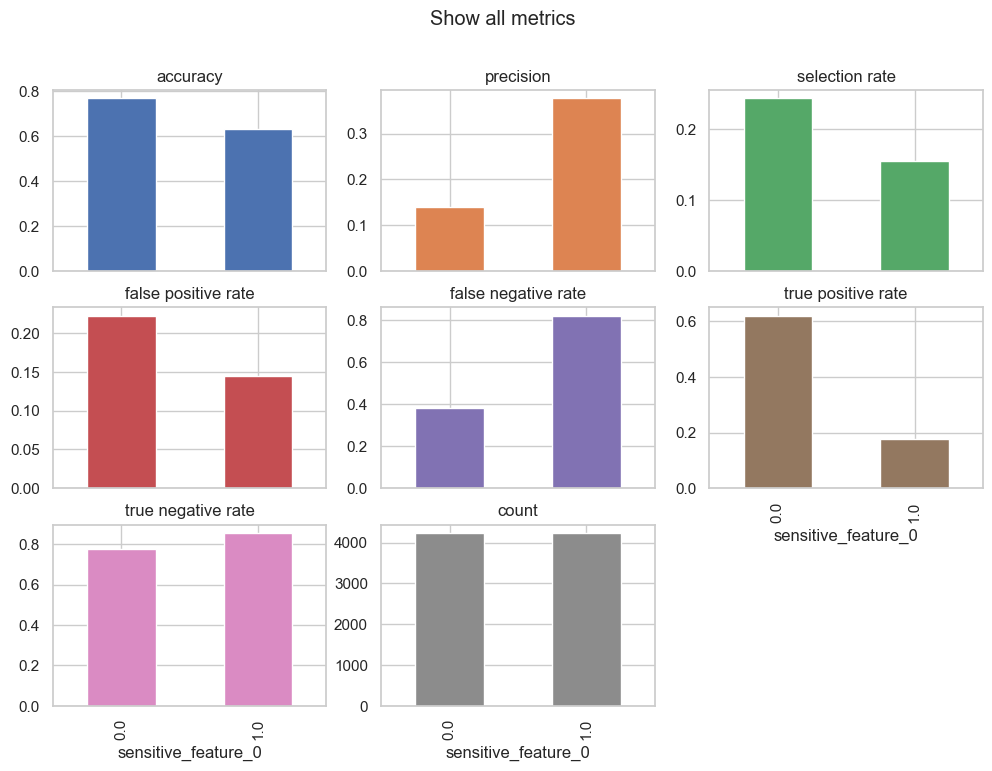

In [63]:
mf = MetricFrame(metrics={"accuracy": accuracy_score,
                        "precision": precision_score,
                        "selection rate": selection_rate,
                        "false positive rate": false_positive_rate,
                        "false negative rate": false_negative_rate,
                        "true positive rate": true_positive_rate,
                        "true negative rate": true_negative_rate,
                        "count": count
                         },
                 y_true=test_lab_distorted,
                 y_pred=test_pred,
                 sensitive_features=test_a)




print("Test set fairness metrics (before mitigation):")
print(mf.by_group)


mf.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Show all metrics",
)

print("Recall is the true positive rate (TPR).")

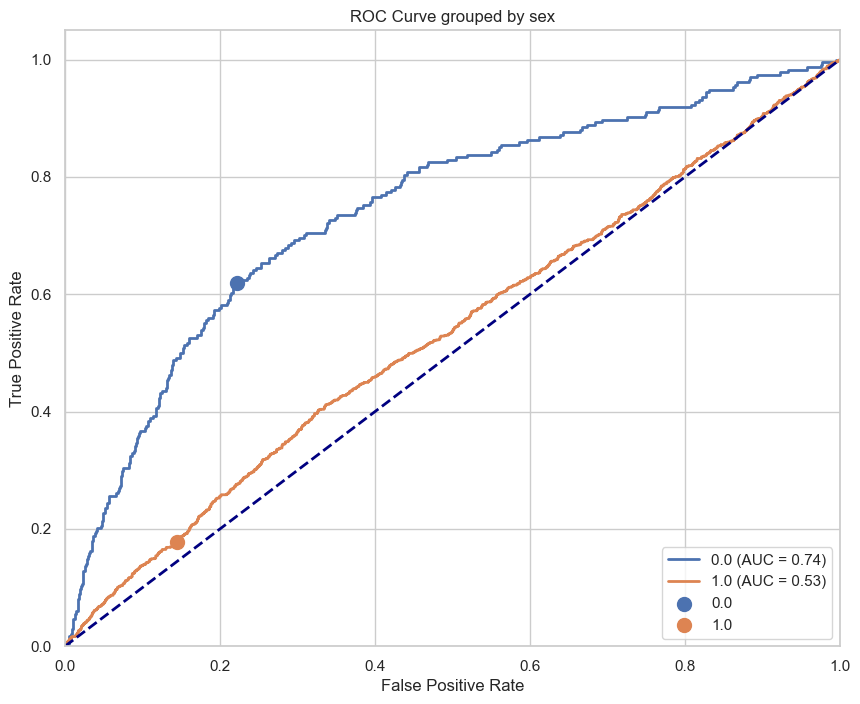

In [69]:
plot_roc_simple(test_lab_distorted, test_prob, test_a, test_pred,
        sensitive_attribute_name = 'sex')

In [65]:
# Separation ratio (equalized odds, same FPR and FNR)
print('Separation ratio:', equalized_odds_ratio(test_lab_distorted, test_pred, sensitive_features=test_a)) 

# Independence ratio
print('Independence ratio:', demographic_parity_ratio(test_lab_distorted, test_pred, sensitive_features=test_a))

# Sufficiency ratio (PPV positive predictive value,  PPV = TP / (TP + FP), precision)
print('Sufficiency ratio (manual):', min(mf.by_group['precision']) / max(mf.by_group['precision']))

Separation ratio: 0.28710235986741206
Independence ratio: 0.6374461670973299
Sufficiency ratio (manual): 0.37278850962740684


After mitigation:

Test set fairness metrics (after mitigation):
                     accuracy  precision  selection rate  false positive rate  \
sensitive_feature_0                                                             
0.0                  0.677938   0.113169        0.344762             0.323655   
1.0                  0.568558   0.361947        0.369031             0.351199   

                     false negative rate  true positive rate  \
sensitive_feature_0                                            
0.0                             0.294872            0.705128   
1.0                             0.594692            0.405308   

                     true negative rate  
sensitive_feature_0                      
0.0                            0.676345  
1.0                            0.648801  


<Axes: xlabel='sensitive_feature_0'>

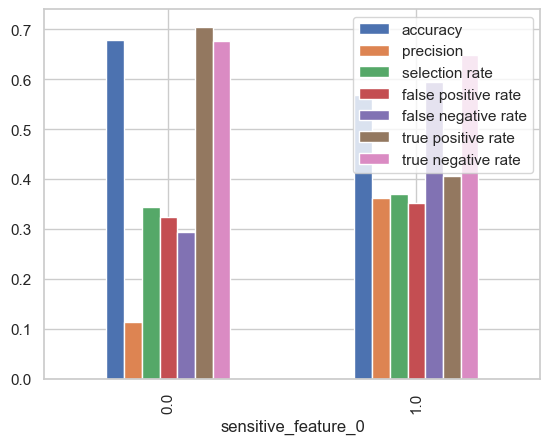

In [66]:
mf = MetricFrame(metrics={"accuracy": accuracy_score,
                        "precision": precision_score,
                        "selection rate": selection_rate,
                        "false positive rate": false_positive_rate,
                        "false negative rate": false_negative_rate,
                        "true positive rate": true_positive_rate,
                        "true negative rate": true_negative_rate,
                         },
                 y_true=test_lab_distorted,
                 y_pred=y_pred_fair_test,
                 sensitive_features=test_a)
print("Test set fairness metrics (after mitigation):")
print(mf.by_group)
mf.by_group.plot.bar()

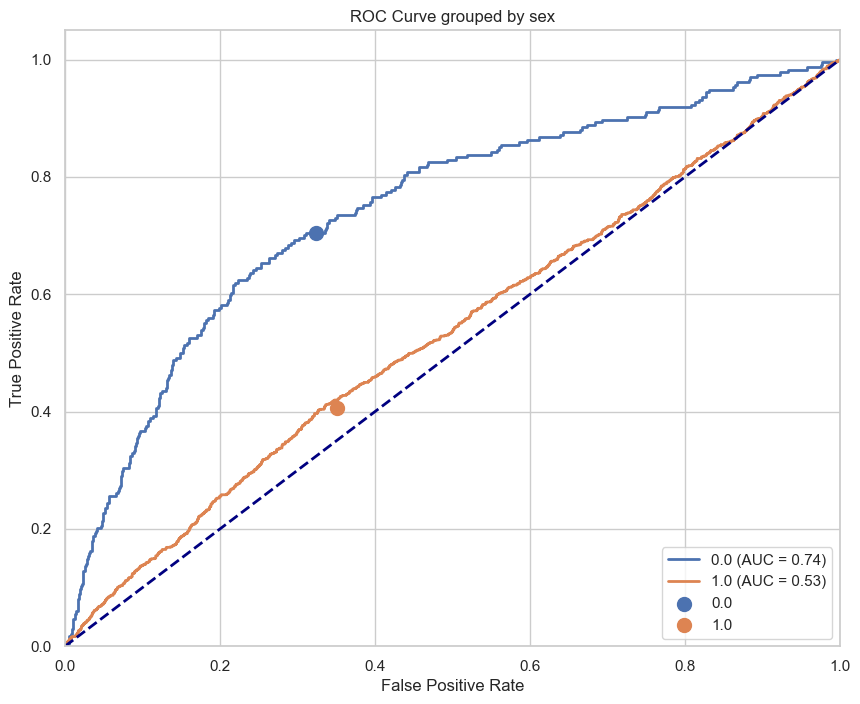

In [68]:
plot_roc_simple(test_lab_distorted, test_prob, test_a, y_pred_fair_test,
        sensitive_attribute_name = 'sex')

In [70]:
# Separation ratio (equalized odds, same FPR and FNR)
print('Separation ratio:', equalized_odds_ratio(test_lab_distorted, y_pred_fair_test, sensitive_features=test_a)) 

# Independence ratio
print('Independence ratio:', demographic_parity_ratio(test_lab_distorted, y_pred_fair_test, sensitive_features=test_a))

# Sufficiency ratio (PPV positive predictive value,  PPV = TP / (TP + FP), precision)
print('Sufficiency ratio (manual):', min(mf.by_group['precision']) / max(mf.by_group['precision']))

Separation ratio: 0.574801095604539
Independence ratio: 0.9342375159225924
Sufficiency ratio (manual): 0.31266615681561605
